In [213]:
import numpy as np
from scipy.signal import periodogram
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from datagen.data_generate_dde import dde_rk45
from systems.ddes import mackeyglass
from estimators.volt_funcs import Volterra
from estimators.volt_custloss_funcs import VolterraCustomLoss
from utils.normalisation import normalise_arrays
from utils.errors import calculate_specdensloss, calculate_mse, calculate_wasserstein1err
from utils.plotting import plot_data, plot_data_distributions

In [205]:
# Generate some dataset

def init(t):
    return 1.2

mg_args = {'delay': 17, 'a': 0.2, 'b': 0.1, 'n': 10 }

h = 0.02
n_intervals = 200
slicing = int(1 / h)

data = dde_rk45(n_intervals, init, mackeyglass, h, mg_args)[1][::slicing]

ndata = len(data)
ntrain = 3001
washout = 1000
ntest = ndata - ntrain

train_in = data[0:ntrain-1]
train_teach = data[1:ntrain]
test_in = data[ntrain-1:ntrain+ntest-1]
test_teach = data[ntrain:ntrain+ntest]

normalisation_output = normalise_arrays([train_in, train_teach, test_in, test_teach], norm_type="ScaleL2Shift")
train_in, train_teach, test_in, test_teach = normalisation_output[0]
shift, scale = normalisation_output[1], normalisation_output[2]

In [86]:
# Getting training error to go down depending on parameter 
# See if the hyperparameter helps with the alpha fitting

from itertools import product
ld_coef_range = np.linspace(0.8, 0.95, 4)
tau_coef_range = np.linspace(0.5, 0.95, 10)
for comb_id, comb in enumerate(product(ld_coef_range, tau_coef_range)):
    ld_coef = round(comb[0], 2)
    tau_coef = round(comb[1], 2)
    volt = VolterraCustomLoss(ld_coef, tau_coef, washout, nfeatures=None, loss_func="specdens", method="BFGS", seed=100, options={'gtol' : 1e-1, 'eps' : 1e-1})
    volt.Train(train_in, train_teach)
    with open("error_param.txt", "a") as file:
        file.write(f"{comb_id}, {volt.optresult['fun']}, {ld_coef}, {tau_coef} \n")

In [215]:
ld_coef, tau_coef = 0.85, 0.7
volt = VolterraCustomLoss(ld_coef, tau_coef, washout, nfeatures=None, loss_func="specdens", method="BFGS", seed=100, options={'gtol' : 1e-3, 'return_all' : True})
volt.Train(train_in, train_teach)
volt.optresult

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.2359294220011513
        x: [ 9.110e-02 -3.995e-01 ... -1.903e-01  7.017e-01]
      nit: 137
      jac: [-4.240e+00  9.469e+00 ...  5.878e+01  7.594e+01]
 hess_inv: [[ 1.004e+00  3.465e-03 ...  1.890e-02  3.203e-02]
            [ 3.488e-03  1.011e+00 ...  4.202e-02  5.652e-02]
            ...
            [ 1.897e-02  4.208e-02 ...  1.146e+00  1.958e-01]
            [ 3.212e-02  5.660e-02 ...  1.958e-01  1.270e+00]]
     nfev: 422219
     njev: 211
  allvecs: [array([ 8.681e-02, -4.433e-01, ..., -2.704e-01,  5.571e-01]), array([ 8.676e-02, -4.431e-01, ..., -2.690e-01,  5.592e-01]), array([ 8.695e-02, -4.437e-01, ..., -2.704e-01,  5.583e-01]), array([ 7.802e-02, -4.540e-01, ..., -2.960e-01,  5.257e-01]), array([-3.781e-02, -5.473e-01, ..., -3.241e-01,  5.251e-01]), array([-4.207e-02, -5.511e-01, ..., -3.269e-01,  5.229e-01]), array([-3.218e-02, -5.431e-01, ..., -3.249e-01, 

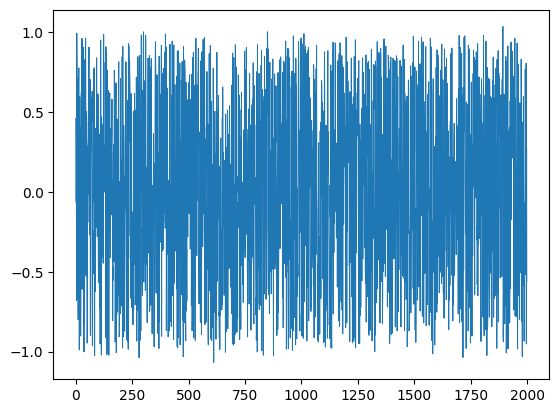

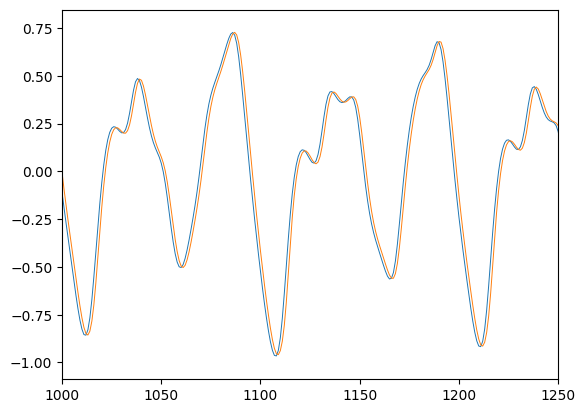

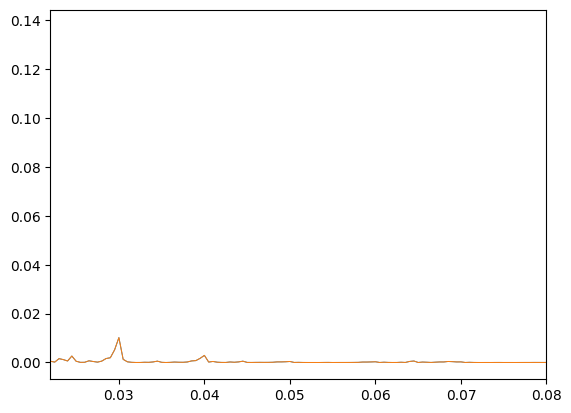

In [212]:
# Check training output

flip = True

Gram_train = volt.Gram[1000:, 1000:]
if not flip:
    train_output = np.matmul(Gram_train, volt.alpha) + volt.alpha0
if flip == True:
    volt.alpha = - volt.optresult['x'].reshape((volt.nfeatures, volt.ntargets), order="F")
    volt.alpha0 = np.mean(train_teach[1000:], axis=0) -  volt.alpha.T @ np.mean(Gram_train, axis=0)
    train_output = np.matmul(Gram_train, volt.alpha) + volt.alpha0

plt.plot(volt.alpha, lw=0.7)
plt.show()
plt.close()

x_space = np.arange(0, 3000, 1)
plt.plot(x_space, train_teach, lw=0.7)
plt.plot(x_space[1000:], train_output, lw=0.7)
plt.xlim(left=1000, right=1250)
plt.show()
plt.close()

freq_true, psd_true = periodogram(train_teach[:, 0][1000:], window="hann", scaling="spectrum")
freq_pred, psd_pred = periodogram(train_output[:, 0], window="hann", scaling="spectrum")
plt.plot(freq_true, psd_true, lw=0.7)
plt.plot(freq_pred, psd_pred, lw=0.7)
plt.xlim((0.022, 0.08))
plt.show()
plt.close()

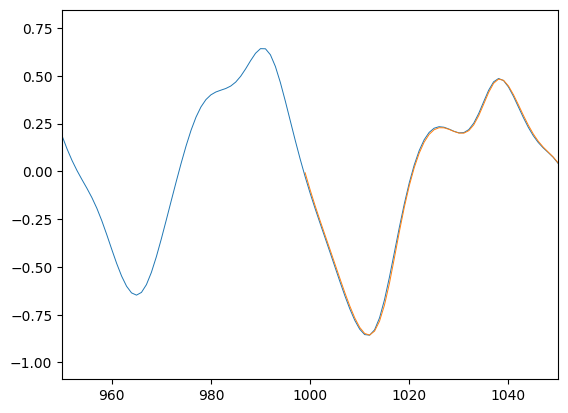

Original spec dens loss: 0.00033078243980113047
Shifted spec dens loss:  0.00028871157796077167


In [135]:
# Check the spec dens error with the shift

x_space = np.arange(0, 3000, 1)
plt.plot(x_space, train_teach, lw=0.7)
plt.plot(x_space[999:2999], train_output, lw=0.7)
plt.xlim(left=950, right=1050)
plt.show()
plt.close()

print("Original spec dens loss:", calculate_specdensloss(train_teach[1000:], train_output))
print("Shifted spec dens loss: ", calculate_specdensloss(train_teach[999:2999], train_output))

In [113]:
# Try refining search to correct the right shift

def loss(alpha):
    alpha = alpha.reshape((volt.nfeatures, volt.ntargets), order="F")
    unshifted_output = np.matmul(Gram_train, alpha)
    error = calculate_specdensloss(train_teach[1000:], unshifted_output)
    return error

rough_alpha_init = volt.alpha.flatten(order="F")
refined_optresult = minimize(loss, rough_alpha_init, method="BFGS", options={'gtol' : 1e-5, 'c1' : 1e-5, 'c2' : 0.99}) 
refined_optresult


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.000330259933299386
        x: [-6.121e-02  4.633e-01 ...  2.712e-01 -5.645e-01]
      nit: 6
      jac: [ 4.173e-03  3.359e-03 ...  2.863e-02  3.714e-02]
 hess_inv: [[ 9.960e-01  2.454e-03 ...  8.520e-03  9.201e-03]
            [ 2.454e-03  9.991e-01 ... -1.911e-03 -1.984e-03]
            ...
            [ 8.520e-03 -1.911e-03 ...  1.001e+00  1.462e-03]
            [ 9.201e-03 -1.984e-03 ...  1.462e-03  1.002e+00]]
     nfev: 114068
     njev: 57

In [141]:
# Try different initial search value to see if it improves the right shift

def loss(alpha):
    alpha = alpha.reshape((volt.nfeatures, volt.ntargets), order="F")
    unshifted_output = np.matmul(Gram_train, alpha)
    error = calculate_specdensloss(train_teach[1000:], unshifted_output)
    return error

match0_init_alpha = np.linalg.lstsq(Gram_train[:, 0].reshape((1, -1)), [train_teach[1000]], rcond=None)[0].flatten(order="F")
match0_optresult = minimize(loss, match0_init_alpha, method="BFGS", options={'gtol' : 1e-7})
match0_optresult

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.2938610215474278
        x: [-3.592e-05 -3.588e-05 ... -3.580e-05 -3.577e-05]
      nit: 0
      jac: [-8.173e-06  2.671e-05 ...  1.862e-04  2.541e-04]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 102057
     njev: 51

In [145]:
# Try combining mse and spec dens loss

def loss_combined(alpha):
    alpha = alpha.reshape((volt.nfeatures, volt.ntargets), order="F")
    alpha0 = np.mean(train_teach[1000:], axis=0) -  alpha.T @ np.mean(Gram_train, axis=0)
    output = np.matmul(Gram_train, alpha) + alpha0
    spec_dens_error = calculate_specdensloss(train_teach[1000:], output)
    mean_square_error = calculate_mse(train_teach[1000:], output)
    error = spec_dens_error + 0.1 * mean_square_error
    return error

np.random.seed(100)
alpha_init = np.random.uniform(low=-1, high=1, size=(volt.nfeatures, ))
combinedloss_optresult = minimize(loss_combined, alpha_init, method="BFGS", options={'gtol' : 1e-2})
combinedloss_optresult 


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.07740203067778131
        x: [ 5.760e-02 -4.668e-01 ... -2.746e-01  5.618e-01]
      nit: 90
      jac: [ 7.344e-04 -1.865e-03 ... -1.134e-02 -1.469e-02]
 hess_inv: [[ 1.014e+00  1.017e-02 ... -9.657e-03 -1.672e-02]
            [ 1.017e-02  1.007e+00 ... -7.786e-03 -1.310e-02]
            ...
            [-9.657e-03 -7.786e-03 ...  1.004e+00  8.117e-03]
            [-1.672e-02 -1.310e-02 ...  8.117e-03  1.016e+00]]
     nfev: 330174
     njev: 165

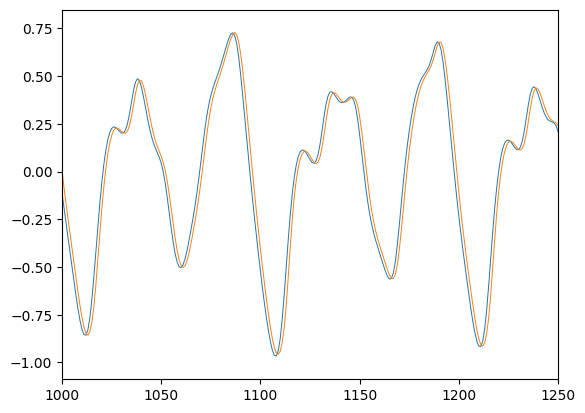

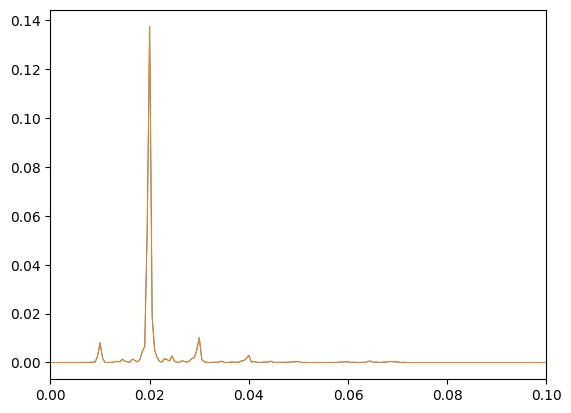

MSE:  0.006928657054746994
Specdens:  0.0003904611786064232


In [159]:
combinedloss_alpha = -combinedloss_optresult['x'].reshape((-1, 1))
combinedloss_alpha0 = np.mean(train_teach[1000:], axis=0) -  combinedloss_alpha.T @ np.mean(Gram_train, axis=0)
combinedloss_train_output = np.matmul(Gram_train, combinedloss_alpha) + combinedloss_alpha0

x_space = np.arange(0, 3000, 1)
plt.plot(x_space, train_teach, lw=0.7)
plt.plot(x_space[1000:], combinedloss_train_output, lw=0.7)
plt.xlim(left=1000, right=1250)
plt.show()
plt.close()

freq_true, psd_true = periodogram(train_teach[:, 0][1000:], window="hann", scaling="spectrum")
freq_pred, psd_pred = periodogram(combinedloss_train_output[:, 0], window="hann", scaling="spectrum")
plt.plot(freq_true, psd_true, lw=0.7)
plt.plot(freq_pred, psd_pred, lw=0.7)
plt.xlim((0, 0.1))
plt.show()
plt.close()

print("MSE: ", calculate_mse(train_teach[1000:], combinedloss_train_output))
print("Specdens: ", calculate_specdensloss(train_teach[1000:], combinedloss_train_output))

In [161]:
# Try different initial search value by choosing another seed to see if it improves the right shift

def loss(alpha):
    alpha = alpha.reshape((volt.nfeatures, volt.ntargets), order="F")
    unshifted_output = np.matmul(Gram_train, alpha)
    error = calculate_specdensloss(train_teach[1000:], unshifted_output)
    return error

np.random.seed(300)
diffseed_init_alpha = np.random.uniform(low=-1, high=1, size=(volt.nfeatures, ))
diffseed_optresult = minimize(loss, diffseed_init_alpha, method="BFGS", options={'gtol' : 1e-2})
diffseed_optresult

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 0.00040413232991440165
        x: [-1.020e-01 -5.647e-01 ... -3.311e-01 -6.273e-01]
      nit: 37
      jac: [-1.184e-03  3.148e-03 ...  1.946e-02  2.540e-02]
 hess_inv: [[ 1.003e+00  3.049e-03 ...  3.852e-03  3.006e-03]
            [ 3.049e-03  1.004e+00 ...  4.665e-03  3.444e-03]
            ...
            [ 3.852e-03  4.665e-03 ...  1.005e+00  3.209e-03]
            [ 3.006e-03  3.444e-03 ...  3.209e-03  1.002e+00]]
     nfev: 194106
     njev: 97

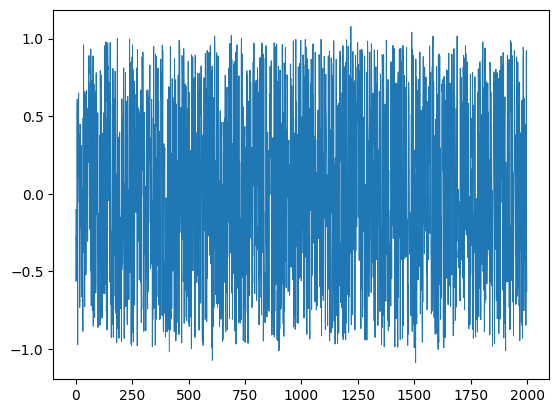

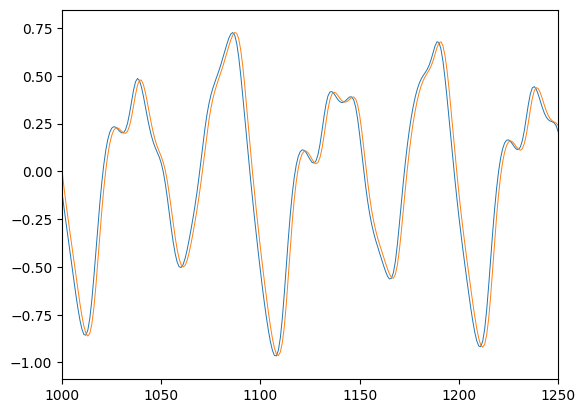

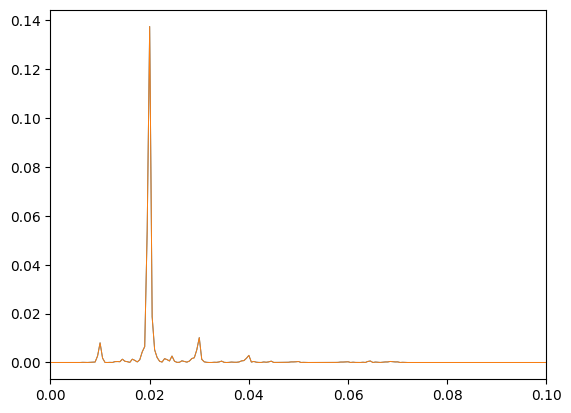

In [165]:
# Check training output

flip = False

Gram_train = volt.Gram[1000:, 1000:]
diffseed_alpha = diffseed_optresult['x'].reshape((volt.nfeatures, volt.ntargets), order="F")
diffseed_alpha0 = np.mean(train_teach[1000:], axis=0) -  diffseed_alpha.T @ np.mean(Gram_train, axis=0)
if not flip:
    train_output = np.matmul(Gram_train, diffseed_alpha) + diffseed_alpha0
if flip == True:
    diffseed_alpha = - diffseed_alpha
    volt.alpha0 = np.mean(train_teach[1000:], axis=0) -  diffseed_alpha.T @ np.mean(Gram_train, axis=0)
    train_output = np.matmul(Gram_train, diffseed_alpha) + diffseed_alpha0

plt.plot(diffseed_alpha, lw=0.7)
plt.show()
plt.close()

x_space = np.arange(0, 3000, 1)
plt.plot(x_space, train_teach, lw=0.7)
plt.plot(x_space[1000:], train_output, lw=0.7)
plt.xlim(left=1000, right=1250)
plt.show()
plt.close()

freq_true, psd_true = periodogram(train_teach[:, 0][1000:], window="hann", scaling="spectrum")
freq_pred, psd_pred = periodogram(train_output[:, 0], window="hann", scaling="spectrum")
plt.plot(freq_true, psd_true, lw=0.7)
plt.plot(freq_pred, psd_pred, lw=0.7)
plt.xlim((0, 0.1))
plt.show()
plt.close()

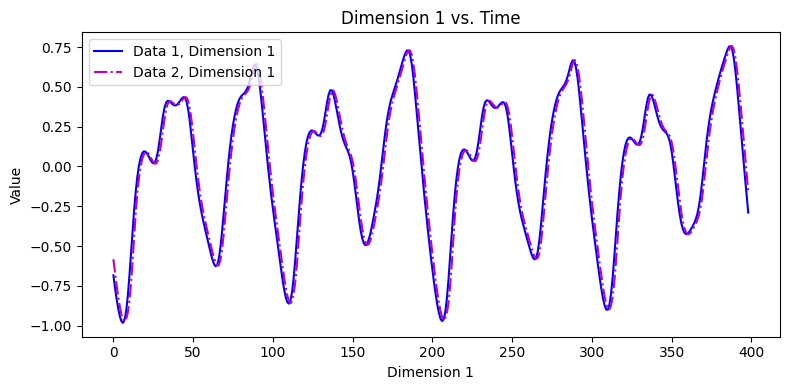

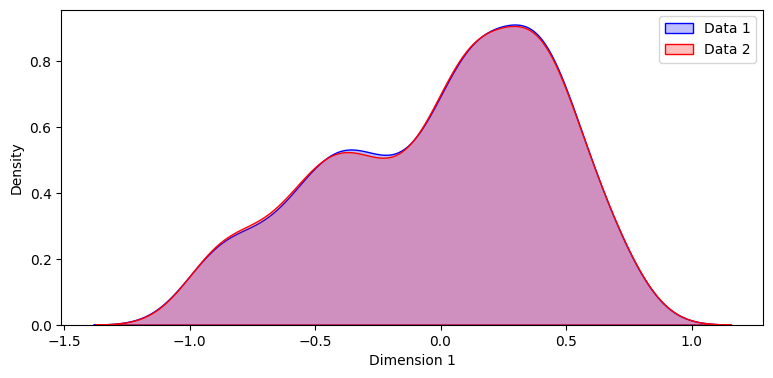

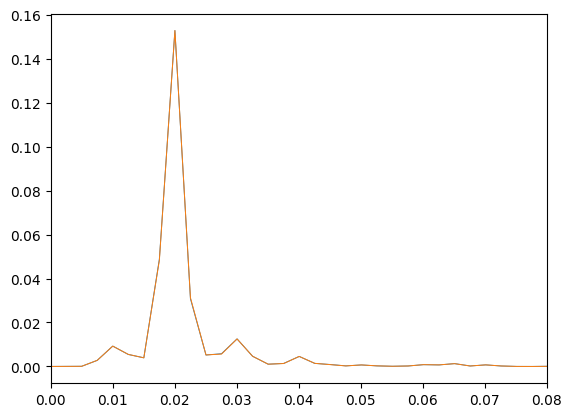

In [172]:
output = volt.Forecast(test_in)

plot_data([test_teach, output])
plot_data_distributions([test_teach, output])

freq_true, psd_true = periodogram(test_teach[:, 0], window="hann", scaling="spectrum")
freq_pred, psd_pred = periodogram(output[:, 0], window="hann", scaling="spectrum")
plt.plot(freq_true, psd_true, lw=0.7)
plt.plot(freq_pred, psd_pred, lw=0.7)
plt.xlim((0, 0.08))
plt.show()
plt.close()

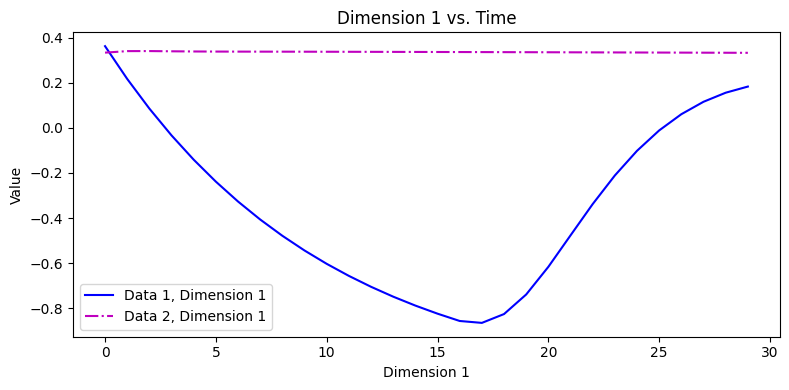

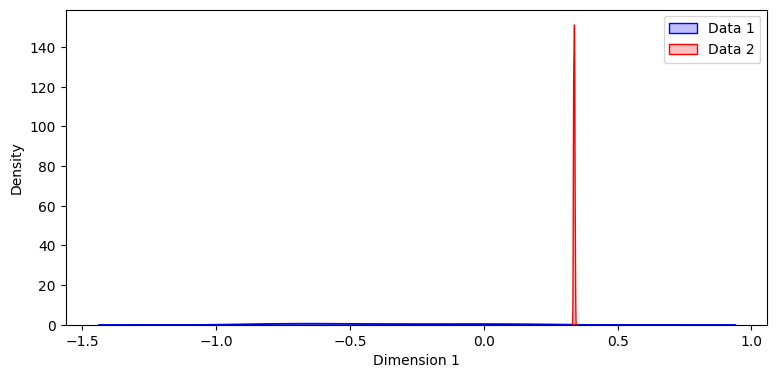

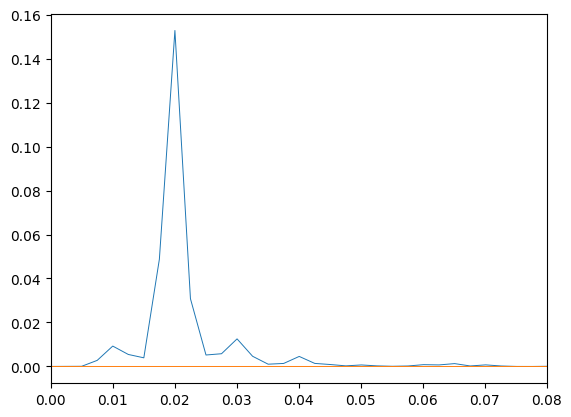

In [174]:
nhorizon = 30
output = volt.PathContinue(train_in[0], nhorizon)

plot_data([train_teach[0:nhorizon], output])
plot_data_distributions([train_teach[0:nhorizon], output])

freq_true, psd_true = periodogram(test_teach[:, 0], window="hann", scaling="spectrum")
freq_pred, psd_pred = periodogram(output[:, 0], window="hann", scaling="spectrum")
plt.plot(freq_true, psd_true, lw=0.7)
plt.plot(freq_pred, psd_pred, lw=0.7)
plt.xlim((0, 0.08))
plt.show()
plt.close()

In [207]:
def loss_mse(alpha):
    alpha = alpha.reshape((volt.nfeatures, volt.ntargets), order="F")
    alpha0 = np.mean(train_teach[1000:], axis=0) - alpha.T @ np.mean(volt.Gram[1000:, 1000:], axis=0)
    output = np.matmul(Gram_train, alpha) + alpha0
    error = calculate_mse(train_teach[1000: ], output)
    return error

mserefine_init_alpha = volt.alpha.flatten(order="F")
mserefine_optresult = minimize(loss_mse, mserefine_init_alpha, method="BFGS", options={'gtol' : 1e-5})
mserefine_optresult

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00036726926331869523
        x: [-3.709e-03 -5.345e-01 ... -3.801e-01  4.589e-01]
      nit: 45
      jac: [-1.548e-07 -3.759e-07 ... -3.086e-07 -3.001e-07]
 hess_inv: [[ 1.318e+00  3.791e-01 ...  6.135e-01  5.914e-01]
            [ 3.791e-01  1.807e+00 ...  2.316e+00  2.467e+00]
            ...
            [ 6.135e-01  2.316e+00 ...  9.257e+00  9.005e+00]
            [ 5.914e-01  2.467e+00 ...  9.005e+00  1.084e+01]]
     nfev: 102051
     njev: 51

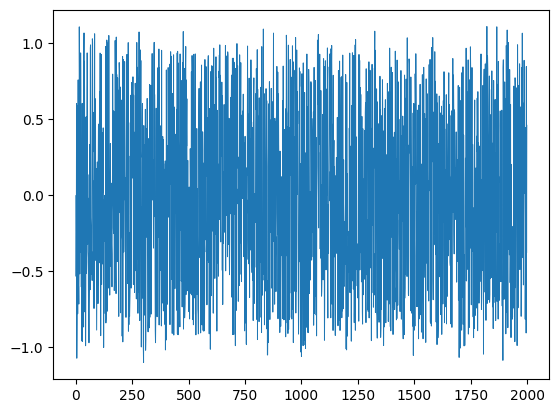

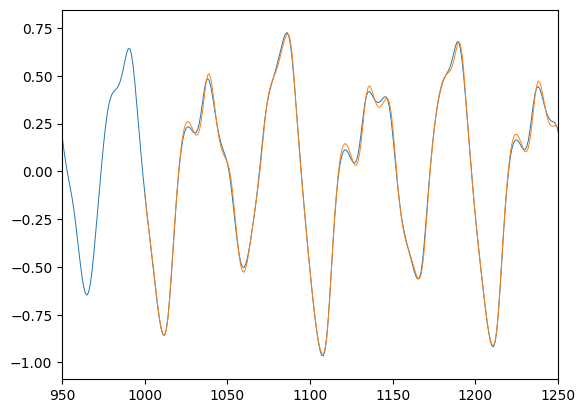

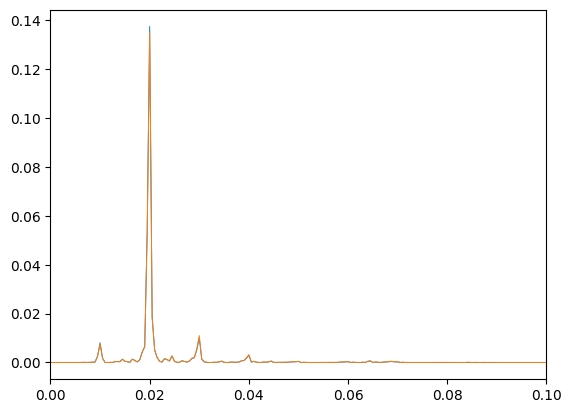

In [208]:
Gram_train = volt.Gram[1000:, 1000:]
mserefine_alpha = mserefine_optresult['x'].reshape((volt.nfeatures, volt.ntargets), order="F")
mserefine_alpha0 = np.mean(train_teach[1000: ], axis=0) - mserefine_alpha.T @ np.mean(Gram_train, axis=0)
mserefine_trainoutput = np.matmul(Gram_train, mserefine_alpha) + mserefine_alpha0

plt.plot(mserefine_alpha, lw=0.7)
plt.show()
plt.close()

x_space = np.arange(0, 3000, 1)
plt.plot(x_space, train_teach, lw=0.7)
plt.plot(x_space[1000:], mserefine_trainoutput, lw=0.7)
plt.xlim(left=950, right=1250)
plt.show()
plt.close()

freq_true, psd_true = periodogram(train_teach[:, 0][1000:], window="hann", scaling="spectrum")
freq_pred, psd_pred = periodogram(mserefine_trainoutput[:, 0], window="hann", scaling="spectrum")
plt.plot(freq_true, psd_true, lw=0.7)
plt.plot(freq_pred, psd_pred, lw=0.7)
plt.xlim((0, 0.1))
plt.show()
plt.close()

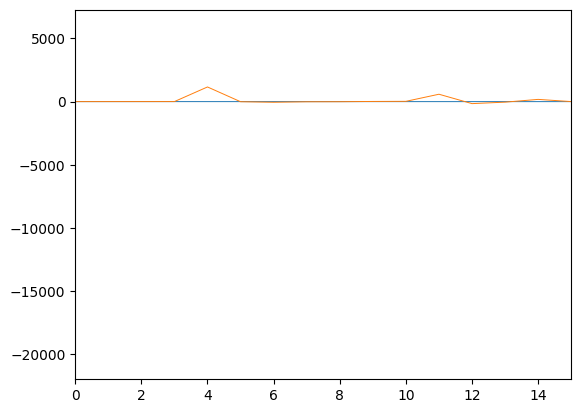

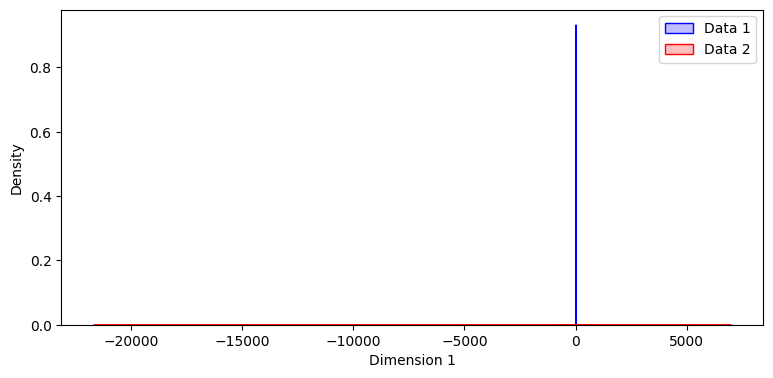

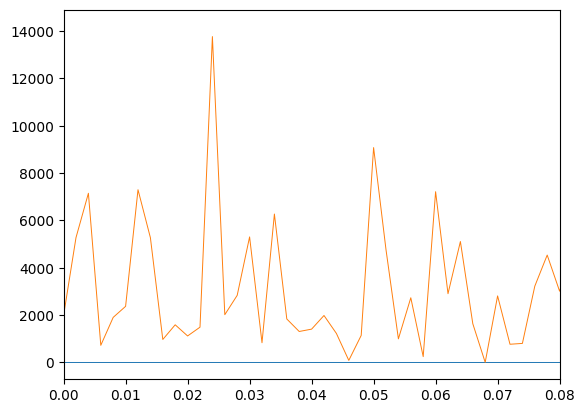

In [196]:
nhorizon = 500
volt.alpha = mserefine_optresult['x'].reshape((volt.nfeatures, volt.ntargets), order="F")
volt.alpha0 = np.mean(train_teach[1000: ], axis=0) - volt.alpha.T @ np.mean(Gram_train, axis=0)
output = volt.PathContinue(train_in[0], nhorizon)

x_space = np.arange(0,  nhorizon, 1)
plt.plot(x_space, train_teach[0:nhorizon], lw=0.7)
plt.plot(x_space, output, lw=0.7)
plt.xlim(left=0, right=15)

plt.show()
plt.close()

plot_data_distributions([train_teach[0:nhorizon], output])

freq_true, psd_true = periodogram(test_teach[:, 0], window="hann", scaling="spectrum")
freq_pred, psd_pred = periodogram(output[:, 0], window="hann", scaling="spectrum")
plt.plot(freq_true, psd_true, lw=0.7)
plt.plot(freq_pred, psd_pred, lw=0.7)
plt.xlim((0, 0.08))
plt.show()
plt.close()